In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)

import polars as pl
pl.enable_string_cache() # TODO: remove eventually with proper enums
from zipfile import ZipFile
from pathlib import Path
from polars import col as C
import plotly.express as px
from ctrace.constants import *
import ctrace as ct
import tempfile

_logger = logging.getLogger(__name__)


In [4]:
# The zip files released by climate trace

_files =  [ 
        "agriculture.zip",
        "buildings.zip",
        "fluorinated_gases.zip", 
        "forestry_and_land_use.zip",
        "fossil_fuel_operations.zip", 
        "manufacturing.zip",
        "mineral_extraction.zip",
         "power.zip",
         "transportation.zip",
        "waste.zip"
            ]

def _recast_parquet(df) -> pl.DataFrame:
    cf_cols = [SOURCE_TYPE, CAPACITY, CAPACITY_FACTOR, ACTIVITY, CO2_EMISSIONS_FACTOR,
         CH4_EMISSIONS_FACTOR, N2O_EMISSIONS_FACTOR, CO2_EMISSIONS, CH4_EMISSIONS, 
        N2O_EMISSIONS, TOTAL_CO2E_20YRGWP, TOTAL_CO2E_100YRGWP]
    return (df.with_columns(
                c_iso3_country.cast(ct.iso3_enum).alias(ISO3_COUNTRY),
                c_gas.cast(ct.gas_enum, strict=False).alias(GAS),
                # TODO: change eventually to enum
                c_original_inventory_sector.cast(pl.String).alias(ORIGINAL_INVENTORY_SECTOR),
                c_temporal_granularity.cast(ct.temporal_granularity_enum).alias(TEMPORAL_GRANULARITY),
            ).with_columns(
        *[C("conf_" + col_name).cast(pl.Categorical, strict=False).alias("conf_" + col_name) for col_name in cf_cols]
            ))

def _load_sources(fp) -> pl.DataFrame:
    dates = [
        START_TIME, END_TIME, CREATED_DATE, MODIFIED_DATE
    ]
    uint64s = [SOURCE_ID]
    floats = [EMISSIONS_QUANTITY, EMISSIONS_FACTOR, CAPACITY, CAPACITY_FACTOR, ACTIVITY, LAT, LON]
    enums = {
        ISO3_COUNTRY:ct.iso3_enum, 
        GAS:ct.gas_enum, 
        TEMPORAL_GRANULARITY:ct.temporal_granularity_enum,
        # TODO: activate once the whole list is gathered
        # ORIGINAL_INVENTORY_SECTOR:ct.inventory_sector_enum
    }
    # TODO: make it lazy
    df = pl.read_csv(fp.read(), infer_schema_length=0) #.lazy()
    num_other = 12
    check_cols = [ACTIVITY, ACTIVITY_UNITS, EMISSIONS_FACTOR, EMISSIONS_FACTOR_UNITS, 
                  CAPACITY_UNITS, CAPACITY, CAPACITY_FACTOR, GEOMETRY_REF, LAT, LON, ORIGINAL_INVENTORY_SECTOR] + [f"other{i}" for i in range(1,num_other+1)] + [f"other{i}_def" for i in range(1,num_other+1)]
    for col_name in check_cols:
        if col_name not in df.columns:
            df = df.with_columns(pl.lit(None).cast(pl.String, strict=False).alias(col_name))
    # Check that the columns match exactly
    s1 = set(df.columns)
    s2 = set(all_columns)
    assert s1 == s2, (s1-s2, s2-s1, list(zip(sorted(df.columns), sorted(all_columns))))
    df = df.select(*all_columns)
    return (df.with_columns(
        # Only start_time and end_time are required
    *[C(col_name).str.to_datetime(strict=(col_name in {START_TIME, END_TIME})).alias(col_name) for col_name in dates])
            .with_columns(
                c_iso3_country.cast(ct.iso3_enum).alias(ISO3_COUNTRY),
                c_gas.cast(ct.gas_enum).alias(GAS),
                c_temporal_granularity.cast(ct.temporal_granularity_enum).alias("temporal_granularity"),
                # TODO: change eventually to enum
                # c_original_inventory_sector.cast(pl.Categorical).alias(ORIGINAL_INVENTORY_SECTOR)
    ).with_columns(*[C(col_name).cast(pl.Float64, strict=False).alias(col_name) for col_name in floats])
            .with_columns(*[C(col_name).cast(pl.UInt64).alias(col_name) for col_name in uint64s])
            # This is for debugging the memory consumption, remove eventually
            .limit(1_000_000_000)
    )

def _load_source_confidence(fp) -> pl.DataFrame:
    dates = [
        START_TIME, END_TIME, CREATED_DATE, MODIFIED_DATE
    ]
    cf_cols = [SOURCE_TYPE, CAPACITY, CAPACITY_FACTOR, ACTIVITY, CO2_EMISSIONS_FACTOR,
         CH4_EMISSIONS_FACTOR, N2O_EMISSIONS_FACTOR, CO2_EMISSIONS, CH4_EMISSIONS, 
        N2O_EMISSIONS, TOTAL_CO2E_20YRGWP, TOTAL_CO2E_100YRGWP]
    uint64s = [SOURCE_ID]
    # TODO: make it lazy
    df = pl.read_csv(fp.read(), infer_schema_length=0) #.lazy()
    sels = ([C(col_name).str.to_datetime(strict=(col_name in {START_TIME, END_TIME})).alias(col_name) for col_name in dates]
           + [c_iso3_country.cast(ct.iso3_enum).alias(ISO3_COUNTRY), c_source_id.cast(pl.UInt64).alias(SOURCE_ID)]
           + [C(col_name).cast(pl.Categorical, strict=False).alias("conf_"+col_name) for col_name in cf_cols]
           )
    df = df.select(*sels)
    # For debugging
    return df #.limit(1_000)

def _load_source_conf(s_fp, c_fp) -> pl.DataFrame:
    s_df = _load_sources(s_fp)
    c_df = _load_source_confidence(c_fp)
    return (s_df.join(c_df.drop(["created_date", "modified_date"]),
                      on=["start_time", "end_time", "iso3_country", "source_id"], 
                      how="left")
      )

def read_all_sources(p: Path) -> pl.DataFrame:
    res_df = None
    # dfs = []
    # TODO: replace by a proper temp directory
    tmp_dir = Path(tempfile.gettempdir())
    data_files = []
    for fname in _files:
        _logger.debug(f"open {fname}")
        zf = ZipFile(Path(ct_data_source) / fname)
        source_names = [n for n in zf.namelist() if n.endswith("-sources.csv")]
        _logger.debug(f"sources: {source_names}")
        for sname in source_names:
            _logger.debug(f"opening {fname} / {sname}")
            c_name = sname.replace("_emissions-sources.csv", "_emissions-sources_confidence.csv")
            _logger.debug(f"opening {fname} / {c_name}")
            df = _load_source_conf(zf.open(sname), zf.open(c_name))
            df = (df.with_columns(
                pl.lit(fname.replace(".zip", "")).cast(pl.Categorical).alias("ct_package"),
                pl.lit(sname.replace("_emissions-sources.csv", "")).cast(pl.Categorical).alias("ct_file")))
            tmp_name = tmp_dir / sname.replace(".csv",".parquet")
            df.write_parquet(tmp_name)
            data_files.append(tmp_name)
            _logger.debug(f"wrote {tmp_name}")
    dfs = []
    for tmp_name in data_files:
        _logger.debug(f"scan {tmp_name}")
        df = pl.scan_parquet(tmp_name)
        df = df.pipe(_recast_parquet)
        dfs.append(df)
    res_df = pl.concat(dfs)
    return res_df

def _load_country_emissions(fp) -> pl.DataFrame:
    dates = [
        START_TIME, END_TIME, CREATED_DATE, MODIFIED_DATE
    ]
    floats = [EMISSIONS_QUANTITY]
    enums = {
        ISO3_COUNTRY:ct.iso3_enum, 
        GAS:ct.gas_enum, 
        TEMPORAL_GRANULARITY:ct.temporal_granularity_enum,
        # TODO: activate once the whole list is gathered
        # ORIGINAL_INVENTORY_SECTOR:ct.inventory_sector_enum
    }
    df = pl.read_csv(fp.read(), infer_schema_length=0)
    all_columns = ['iso3_country',
             'start_time',
             'end_time',
             'original_inventory_sector',
             'gas',
             'emissions_quantity',
             'emissions_quantity_units',
             'temporal_granularity',
             'created_date',
             'modified_date']
    # Check that the columns match exactly
    s1 = set(df.columns)
    s2 = set(all_columns)
    assert s1 == s2, (s1-s2, s2-s1, list(zip(sorted(df.columns), sorted(all_columns))))
    df = df.select(*all_columns)
    return (df.with_columns(
        # Only start_time and end_time are required
    *[C(col_name).str.to_datetime(format="%Y-%m-%d %H:%M:%S%.f",
                                  strict=(col_name in {START_TIME, END_TIME})).alias(col_name) for col_name in dates])
            .with_columns(
                c_iso3_country.cast(ct.iso3_enum).alias(ISO3_COUNTRY),
                c_gas.cast(ct.gas_enum, strict=False).alias(GAS),
                # TODO: causing issues
                # c_original_inventory_sector.cast(pl.Categorical).alias(ORIGINAL_INVENTORY_SECTOR),
                c_temporal_granularity.cast(ct.temporal_granularity_enum).alias(TEMPORAL_GRANULARITY)
    ).with_columns(*[C(col_name).cast(pl.Float64, strict=False).alias(col_name) for col_name in floats])
    )


def read_country_emissions(p: Path) -> pl.DataFrame:
    # TODO: add meta info about the provenance: ct_package and ct_file
    # So fast there is no need to store a materialized version.
    dfs = []
    for fname in _files:
        _logger.debug(f"open {fname}")
        zf = ZipFile(Path(ct_data_source) / fname)
        source_names = [n for n in zf.namelist() if n.endswith("_country_emissions.csv")]
        _logger.debug(f"sources: {source_names}")
        for sname in source_names:
            _logger.debug(f"opening {fname} / {sname}")
            df = _load_country_emissions(zf.open(sname))
            df = (df.with_columns(
                pl.lit(fname.replace(".zip", "")).cast(pl.Categorical).alias(CT_PACKAGE),
                pl.lit(sname.replace("_country_emissions.csv", "")).cast(pl.Categorical).alias(CT_FILE)))
            dfs.append(df)
    res_df = pl.concat(dfs)
    return res_df
    

ct_data_source = "/home/tjhunter/Downloads/"
cedf = read_country_emissions(Path(ct_data_source))

if False:
    df = read_all_sources(Path(ct_data_source))
    # Using snappy because it is more broadly compatible with parquet readers
    # Polars 0.20 does not support statistics
    for year in range(2015, 2023):
        df.filter(c_start_time.dt.year()==year).sink_parquet(
            f"/home/tjhunter/Downloads/ct_data_{year}.parquet",
                    compression="snappy",
                    statistics=False
                   )


DEBUG:__main__:open agriculture.zip


DEBUG:__main__:sources: ['enteric-fermentation-other_country_emissions.csv', 'other-agricultural-soil-emissions_country_emissions.csv', 'manure-management-other_country_emissions.csv', 'rice-cultivation_country_emissions.csv', 'enteric-fermentation-cattle-feedlot_country_emissions.csv', 'manure-management-cattle-feedlot_country_emissions.csv', 'synthetic-fertilizer-application_country_emissions.csv', 'cropland-fires_country_emissions.csv', 'enteric-fermentation-cattle-pasture_country_emissions.csv', 'manure-left-on-pasture-cattle_country_emissions.csv']


DEBUG:__main__:opening agriculture.zip / enteric-fermentation-other_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / other-agricultural-soil-emissions_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / manure-management-other_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / rice-cultivation_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / enteric-fermentation-cattle-feedlot_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / manure-management-cattle-feedlot_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / synthetic-fertilizer-application_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / cropland-fires_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / enteric-fermentation-cattle-pasture_country_emissions.csv


DEBUG:__main__:opening agriculture.zip / manure-left-on-pasture-cattle_country_emissions.csv


DEBUG:__main__:open buildings.zip


DEBUG:__main__:sources: ['other-onsite-fuel-usage_country_emissions.csv', 'residential-and-commercial-onsite-fuel-usage_country_emissions.csv']


DEBUG:__main__:opening buildings.zip / other-onsite-fuel-usage_country_emissions.csv


DEBUG:__main__:opening buildings.zip / residential-and-commercial-onsite-fuel-usage_country_emissions.csv


DEBUG:__main__:open fluorinated_gases.zip


DEBUG:__main__:sources: ['fluorinated-gases_country_emissions.csv']


DEBUG:__main__:opening fluorinated_gases.zip / fluorinated-gases_country_emissions.csv


DEBUG:__main__:open forestry_and_land_use.zip


DEBUG:__main__:sources: ['water-reservoirs_country_emissions.csv', 'forest-land-degradation_country_emissions.csv', 'shrubgrass-fires_country_emissions.csv', 'wetland-fires_country_emissions.csv', 'net-shrubgrass_country_emissions.csv', 'forest-land-fires_country_emissions.csv', 'removals_country_emissions.csv', 'net-wetland_country_emissions.csv', 'net-forest-land_country_emissions.csv', 'forest-land-clearing_country_emissions.csv']


DEBUG:__main__:opening forestry_and_land_use.zip / water-reservoirs_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / forest-land-degradation_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / shrubgrass-fires_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / wetland-fires_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / net-shrubgrass_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / forest-land-fires_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / removals_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / net-wetland_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / net-forest-land_country_emissions.csv


DEBUG:__main__:opening forestry_and_land_use.zip / forest-land-clearing_country_emissions.csv


DEBUG:__main__:open fossil_fuel_operations.zip


DEBUG:__main__:sources: ['other-fossil-fuel-operations_country_emissions.csv', 'solid-fuel-transformation_country_emissions.csv', 'oil-and-gas-refining_country_emissions.csv', 'coal-mining_country_emissions.csv', 'oil-and-gas-production-and-transport_country_emissions.csv']


DEBUG:__main__:opening fossil_fuel_operations.zip / other-fossil-fuel-operations_country_emissions.csv


DEBUG:__main__:opening fossil_fuel_operations.zip / solid-fuel-transformation_country_emissions.csv


DEBUG:__main__:opening fossil_fuel_operations.zip / oil-and-gas-refining_country_emissions.csv


DEBUG:__main__:opening fossil_fuel_operations.zip / coal-mining_country_emissions.csv


DEBUG:__main__:opening fossil_fuel_operations.zip / oil-and-gas-production-and-transport_country_emissions.csv


DEBUG:__main__:open manufacturing.zip


DEBUG:__main__:sources: ['petrochemicals_country_emissions.csv', 'other-manufacturing_country_emissions.csv', 'pulp-and-paper_country_emissions.csv', 'chemicals_country_emissions.csv', 'aluminum_country_emissions.csv', 'steel_country_emissions.csv', 'cement_country_emissions.csv']


DEBUG:__main__:opening manufacturing.zip / petrochemicals_country_emissions.csv


DEBUG:__main__:opening manufacturing.zip / other-manufacturing_country_emissions.csv


DEBUG:__main__:opening manufacturing.zip / pulp-and-paper_country_emissions.csv


DEBUG:__main__:opening manufacturing.zip / chemicals_country_emissions.csv


DEBUG:__main__:opening manufacturing.zip / aluminum_country_emissions.csv


DEBUG:__main__:opening manufacturing.zip / steel_country_emissions.csv


DEBUG:__main__:opening manufacturing.zip / cement_country_emissions.csv


DEBUG:__main__:open mineral_extraction.zip


DEBUG:__main__:sources: ['rock-quarrying_country_emissions.csv', 'sand-quarrying_country_emissions.csv', 'copper-mining_country_emissions.csv', 'iron-mining_country_emissions.csv', 'bauxite-mining_country_emissions.csv']


DEBUG:__main__:opening mineral_extraction.zip / rock-quarrying_country_emissions.csv


DEBUG:__main__:opening mineral_extraction.zip / sand-quarrying_country_emissions.csv


DEBUG:__main__:opening mineral_extraction.zip / copper-mining_country_emissions.csv


DEBUG:__main__:opening mineral_extraction.zip / iron-mining_country_emissions.csv


DEBUG:__main__:opening mineral_extraction.zip / bauxite-mining_country_emissions.csv


DEBUG:__main__:open power.zip


DEBUG:__main__:sources: ['other-energy-use_country_emissions.csv', 'electricity-generation_country_emissions.csv']


DEBUG:__main__:opening power.zip / other-energy-use_country_emissions.csv


DEBUG:__main__:opening power.zip / electricity-generation_country_emissions.csv


DEBUG:__main__:open transportation.zip


DEBUG:__main__:sources: ['other-transport_country_emissions.csv', 'railways_country_emissions.csv', 'road-transportation_country_emissions.csv', 'international-aviation_country_emissions.csv', 'domestic-aviation_country_emissions.csv', 'international-shipping_country_emissions.csv', 'domestic-shipping_country_emissions.csv']


DEBUG:__main__:opening transportation.zip / other-transport_country_emissions.csv


DEBUG:__main__:opening transportation.zip / railways_country_emissions.csv


DEBUG:__main__:opening transportation.zip / road-transportation_country_emissions.csv


DEBUG:__main__:opening transportation.zip / international-aviation_country_emissions.csv


DEBUG:__main__:opening transportation.zip / domestic-aviation_country_emissions.csv


DEBUG:__main__:opening transportation.zip / international-shipping_country_emissions.csv


DEBUG:__main__:opening transportation.zip / domestic-shipping_country_emissions.csv


DEBUG:__main__:open waste.zip


DEBUG:__main__:sources: ['incineration-and-open-burning-of-waste_country_emissions.csv', 'biological-treatment-of-solid-waste-and-biogenic_country_emissions.csv', 'solid-waste-disposal_country_emissions.csv', 'wastewater-treatment-and-discharge_country_emissions.csv']


DEBUG:__main__:opening waste.zip / incineration-and-open-burning-of-waste_country_emissions.csv


DEBUG:__main__:opening waste.zip / biological-treatment-of-solid-waste-and-biogenic_country_emissions.csv


DEBUG:__main__:opening waste.zip / solid-waste-disposal_country_emissions.csv


DEBUG:__main__:opening waste.zip / wastewater-treatment-and-discharge_country_emissions.csv


In [5]:
cedf

shape: (512_110, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ iso3_coun ┆ start_tim ┆ end_time  ┆ original_ ┆ … ┆ created_d ┆ modified_ ┆ ct_packag ┆ ct_file  │
│ try       ┆ e         ┆ ---       ┆ inventory ┆   ┆ ate       ┆ date      ┆ e         ┆ ---      │
│ ---       ┆ ---       ┆ datetime[ ┆ _sector   ┆   ┆ ---       ┆ ---       ┆ ---       ┆ cat      │
│ enum      ┆ datetime[ ┆ ns]       ┆ ---       ┆   ┆ datetime[ ┆ datetime[ ┆ cat       ┆          │
│           ┆ ns]       ┆           ┆ str       ┆   ┆ ns]       ┆ ns]       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AUT       ┆ 2022-01-0 ┆ 2022-12-3 ┆ enteric-f ┆ … ┆ 2023-10-2 ┆ null      ┆ agricultu ┆ enteric- │
│           ┆ 1         ┆ 1         ┆ ermentati ┆   ┆ 3 11:43:0 ┆           ┆ re        ┆ fermenta │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ on-other  ┆   ┆ 8.395355  ┆           ┆           ┆ tion-oth │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ er       │
│ AZE       ┆ 2022-01-0 ┆ 2022-12-3 ┆ enteric-f ┆ … ┆ 2023-10-2 ┆ null      ┆ agricultu ┆ enteric- │
│           ┆ 1         ┆ 1         ┆ ermentati ┆   ┆ 3 11:43:0 ┆           ┆ re        ┆ fermenta │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ on-other  ┆   ┆ 8.395355  ┆           ┆           ┆ tion-oth │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ er       │
│ ABW       ┆ 2022-01-0 ┆ 2022-12-3 ┆ enteric-f ┆ … ┆ 2023-10-2 ┆ null      ┆ agricultu ┆ enteric- │
│           ┆ 1         ┆ 1         ┆ ermentati ┆   ┆ 3 11:43:0 ┆           ┆ re        ┆ fermenta │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ on-other  ┆   ┆ 8.395355  ┆           ┆           ┆ tion-oth │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ er       │
│ ABW       ┆ 2022-01-0 ┆ 2022-12-3 ┆ enteric-f ┆ … ┆ 2023-10-2 ┆ null      ┆ agricultu ┆ enteric- │
│           ┆ 1         ┆ 1         ┆ ermentati ┆   ┆ 3 11:43:0 ┆           ┆ re        ┆ fermenta │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ on-other  ┆   ┆ 8.395355  ┆           ┆           ┆ tion-oth │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ er       │
│ ABW       ┆ 2022-01-0 ┆ 2022-12-3 ┆ enteric-f ┆ … ┆ 2023-10-2 ┆ null      ┆ agricultu ┆ enteric- │
│           ┆ 1         ┆ 1         ┆ ermentati ┆   ┆ 3 11:43:0 ┆           ┆ re        ┆ fermenta │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ on-other  ┆   ┆ 8.395355  ┆           ┆           ┆ tion-oth │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ er       │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ TUV       ┆ 2016-01-0 ┆ 2016-12-3 ┆ wastewate ┆ … ┆ 2023-10-0 ┆ 2023-11-0 ┆ waste     ┆ wastewat │
│           ┆ 1         ┆ 1         ┆ r-treatme ┆   ┆ 6 14:56:3 ┆ 3 15:13:2 ┆           ┆ er-treat │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ nt-and-di ┆   ┆ 3.428328  ┆ 7.777139  ┆           ┆ ment-and │
│           ┆           ┆           ┆ schar…    ┆   ┆           ┆           ┆           ┆ -dischar │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│ UGA       ┆ 2016-01-0 ┆ 2016-12-3 ┆ wastewate ┆ … ┆ 2023-10-0 ┆ 2023-11-0 ┆ waste     ┆ wastewat │
│           ┆ 1         ┆ 1         ┆ r-treatme ┆   ┆ 6 14:56:3 ┆ 3 15:13:2 ┆           ┆ er-treat │
│           ┆ 00:00:00  ┆ 00:00:00  ┆ nt-and-di ┆   ┆ 3.428328  ┆ 8.159334  ┆           ┆ ment-and │
│           ┆           ┆           ┆ schar…    ┆   ┆           ┆           ┆           ┆ -dischar │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ …        │
│ UGA       ┆ 2015-01-0 ┆ 2015-12-3 ┆ wastewate ┆ … ┆ 2023-10-0 ┆ 2023-11-0 ┆ waste     ┆ wastewat │
│           ┆ 1         ┆ 1         ┆ r-

# Country checks

In [6]:
gas = "co2e_100yr"
year = 2022

cedf_gy = cedf.filter(c_gas == gas).filter(c_start_time.dt.year()==year)

In [7]:
((cedf_gy
 .filter(c_emissions_quantity > 0) # I think this is the most relevant, but to check
)[EMISSIONS_QUANTITY].sum(),
(cedf_gy
)[EMISSIONS_QUANTITY].sum())

(76430900242.65804, 55171507719.83738)

In [8]:
px.bar(cedf_gy
    .filter(c_emissions_quantity > 0)
    .group_by(c_iso3_country)
    .agg(c_emissions_quantity.sum())
    .sort([c_emissions_quantity], descending=True)
    .head(20)
,x=ISO3_COUNTRY, y=EMISSIONS_QUANTITY,log_y=True)

# Mozambique emits more than Germany??

In [9]:
px.bar(cedf_gy
    .group_by(c_iso3_country, c_original_inventory_sector)
    .agg(c_emissions_quantity.sum())
    .sort([c_emissions_quantity], descending=True)
    .filter(c_iso3_country.is_in([
        "CHN", "USA", "IND", "RUS",
        # "MOZ",
        "FRA", "NLD"]))
,x=ISO3_COUNTRY, y=EMISSIONS_QUANTITY,color=ORIGINAL_INVENTORY_SECTOR,log_y=False)

# Chinese forests remove more than all of france emissions

In [10]:
px.bar(cedf_gy
    .group_by(c_original_inventory_sector)
    .agg(c_emissions_quantity.sum())
    .sort([c_emissions_quantity], descending=True)
    .head(10)
,x=ORIGINAL_INVENTORY_SECTOR, y=EMISSIONS_QUANTITY,log_y=False)

In [11]:
px.bar(cedf_gy
    .group_by(c_original_inventory_sector)
    .agg(c_emissions_quantity.sum())
    .sort([c_emissions_quantity], descending=True)
    .tail(5)
,x=ORIGINAL_INVENTORY_SECTOR, y=EMISSIONS_QUANTITY,log_y=False)

# Source analysis

In [12]:


# Parquet loses enum structures.
sdf = (pl.scan_parquet(f"/home/tjhunter/Downloads/ct_data_{year}.parquet").pipe(_recast_parquet)
      )
sdf_gy = sdf.filter(c_gas == gas) #.collect()

In [13]:
sdf.select((c_start_time.dt.year())).min().collect() #.group_by("conf_total_co2e_100yrgwp").count().collect()

shape: (1, 1)
┌────────────┐
│ start_time │
│ ---        │
│ i32        │
╞════════════╡
│ 2022       │
└────────────┘

Number of distinct sources for last year

In [14]:
sdf_gy.select(c_source_id.unique_counts()).count().collect().item()

627582

In [15]:
(sdf.filter(c_original_inventory_sector.is_null())
 .group_by(c_start_time.dt.year(), C("ct_package"), C("ct_file"))
 .agg(pl.count())
 .collect())

/tmp/ipykernel_1880515/3687814498.py:3: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



shape: (9, 4)
┌────────────┬───────────────────────┬─────────────────────────┬────────┐
│ start_time ┆ ct_package            ┆ ct_file                 ┆ count  │
│ ---        ┆ ---                   ┆ ---                     ┆ ---    │
│ i32        ┆ cat                   ┆ cat                     ┆ u32    │
╞════════════╪═══════════════════════╪═════════════════════════╪════════╡
│ 2022       ┆ forestry_and_land_use ┆ wetland-fires           ┆ 32730  │
│ 2022       ┆ forestry_and_land_use ┆ forest-land-clearing    ┆ 211315 │
│ 2022       ┆ forestry_and_land_use ┆ shrubgrass-fires        ┆ 93935  │
│ 2022       ┆ forestry_and_land_use ┆ net-wetland             ┆ 213760 │
│ 2022       ┆ forestry_and_land_use ┆ net-shrubgrass          ┆ 248045 │
│ 2022       ┆ forestry_and_land_use ┆ forest-land-fires       ┆ 81120  │
│ 2022       ┆ forestry_and_land_use ┆ net-forest-land         ┆ 248300 │
│ 2022       ┆ forestry_and_land_use ┆ forest-land-degradation ┆ 94420  │
│ 2022       ┆ forestry_and_land_use ┆ removals                ┆ 250620 │
└────────────┴───────────────────────┴─────────────────────────┴────────┘

In [16]:
px.bar(sdf
 .select(c_original_inventory_sector.value_counts(sort=True))
 .collect()
 .unnest(ORIGINAL_INVENTORY_SECTOR),
      x=ORIGINAL_INVENTORY_SECTOR, y="count", log_y=True)

ModuleNotFoundError: No module named 'pyarrow'

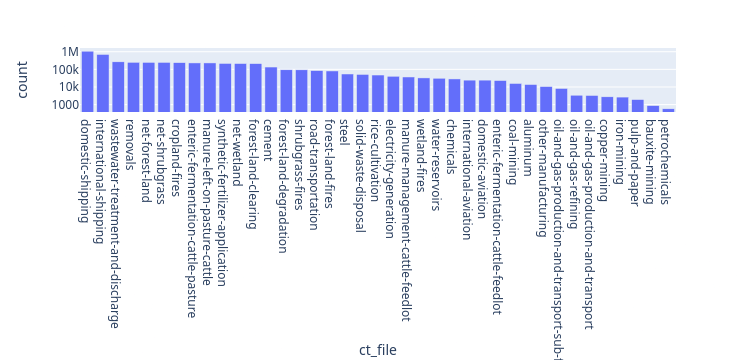

In [17]:
px.bar(sdf.select(C("ct_file").value_counts(sort=True)).collect()
       .unnest("ct_file"),
       x="ct_file", y="count",log_y=True)

In [18]:
(sdf_gy
 .group_by(c_original_inventory_sector)
 .agg(c_source_id.count().alias("c"), c_emissions_quantity.sum())
 .collect()
 .sort("c", descending=True))

shape: (31, 3)
┌───────────────────────────────────┬────────┬────────────────────┐
│ original_inventory_sector         ┆ c      ┆ emissions_quantity │
│ ---                               ┆ ---    ┆ ---                │
│ str                               ┆ u32    ┆ f64                │
╞═══════════════════════════════════╪════════╪════════════════════╡
│ null                              ┆ 294849 ┆ -3.8651e9          │
│ domestic-shipping                 ┆ 213983 ┆ 1.9471e8           │
│ international-shipping            ┆ 139957 ┆ 5.1798e8           │
│ wastewater-treatment-and-dischar… ┆ 53466  ┆ 1.3067e8           │
│ …                                 ┆ …      ┆ …                  │
│ iron-mining                       ┆ 536    ┆ 7.1405542e7        │
│ pulp-and-paper                    ┆ 387    ┆ 8.3640643e7        │
│ bauxite-mining                    ┆ 175    ┆ 8.114666e6         │
│ petrochemicals                    ┆ 116    ┆ 1.4665e8           │
└───────────────────────────────────┴────────┴────────────────────┘

In [19]:
(sdf_gy
.group_by(c_iso3_country, c_original_inventory_sector)
 .agg(c_emissions_quantity.sum())
     .sort([c_emissions_quantity], descending=True)
 .filter(c_iso3_country.is_in(["CHN", "USA", "FRA"]))
 .collect()
)

shape: (83, 3)
┌──────────────┬───────────────────────────────────┬────────────────────┐
│ iso3_country ┆ original_inventory_sector         ┆ emissions_quantity │
│ ---          ┆ ---                               ┆ ---                │
│ enum         ┆ str                               ┆ f64                │
╞══════════════╪═══════════════════════════════════╪════════════════════╡
│ CHN          ┆ electricity-generation            ┆ 4.5421e9           │
│ USA          ┆ electricity-generation            ┆ 1.4893e9           │
│ CHN          ┆ coal-mining                       ┆ 1.0123e9           │
│ CHN          ┆ steel                             ┆ 9.22971074e8       │
│ …            ┆ …                                 ┆ …                  │
│ FRA          ┆ oil-and-gas-production-and-trans… ┆ 86660.769884       │
│ FRA          ┆ rice-cultivation                  ┆ 0.0                │
│ FRA          ┆ null                              ┆ -4.5304e7          │
│ CHN          ┆ null                              ┆ -6.4086e8          │
└──────────────┴───────────────────────────────────┴────────────────────┘

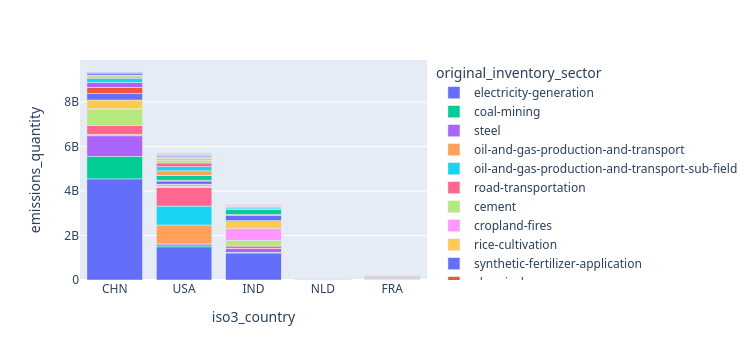

In [20]:
px.bar(
(sdf_gy
 .filter(c_emissions_quantity > 0 )
.group_by(c_iso3_country, c_original_inventory_sector)
 .agg(c_emissions_quantity.sum())
     .sort([c_emissions_quantity], descending=True)
 .filter(c_iso3_country.is_in(["CHN", "USA", "FRA", "NLD", "IND"]))
 .collect()
)
    
    ,x=ISO3_COUNTRY, y=EMISSIONS_QUANTITY,color=ORIGINAL_INVENTORY_SECTOR,log_y=False)

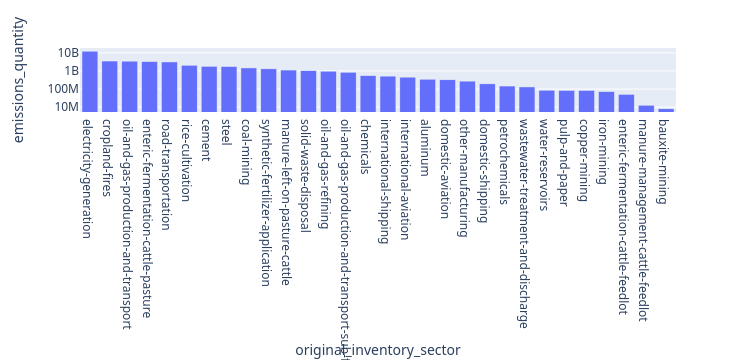

In [21]:
px.bar(
(sdf_gy
.group_by(c_original_inventory_sector)
 .agg(c_emissions_quantity.sum())
     .sort([c_emissions_quantity], descending=True)
 .collect()
),
    
    x=ORIGINAL_INVENTORY_SECTOR,y="emissions_quantity",log_y=True)

# Joint analysis

In [22]:
cedf_gy_agg = (cedf_gy
    .group_by(c_iso3_country, c_ct_package, c_ct_file)
    .agg(c_emissions_quantity.sum())
              )

sdf_gy_agg = (sdf_gy
    .group_by(c_iso3_country, c_ct_package, c_ct_file)
    .agg(c_emissions_quantity.sum())
    .collect()
)

Total emissions from country inventory

In [23]:
(cedf_gy_agg
 .with_columns((c_emissions_quantity > 0).alias("is_emission"))
 .group_by("is_emission")
 .agg(c_emissions_quantity.sum())
 .sort("is_emission")
)

shape: (2, 2)
┌─────────────┬────────────────────┐
│ is_emission ┆ emissions_quantity │
│ ---         ┆ ---                │
│ bool        ┆ f64                │
╞═════════════╪════════════════════╡
│ false       ┆ -2.1259e10         │
│ true        ┆ 7.6431e10          │
└─────────────┴────────────────────┘

Total emissions from source inventory

In [24]:
(sdf_gy_agg
 .with_columns((c_emissions_quantity > 0).alias("is_emission"))
 .group_by("is_emission")
 .agg(c_emissions_quantity.sum())
 .sort("is_emission")
)

shape: (2, 2)
┌─────────────┬────────────────────┐
│ is_emission ┆ emissions_quantity │
│ ---         ┆ ---                │
│ bool        ┆ f64                │
╞═════════════╪════════════════════╡
│ false       ┆ -5.7529e10         │
│ true        ┆ 9.5150e10          │
└─────────────┴────────────────────┘

TODO: there is a significant discrepancy between the total reported for each report.

In [25]:
EMISSIONS_QUANTITY_S = EMISSIONS_QUANTITY + "_s"
EMISSIONS_QUANTITY_CE = EMISSIONS_QUANTITY + "_ce"
jdf = (cedf_gy_agg
       .join(sdf_gy_agg, on=[ISO3_COUNTRY, CT_PACKAGE, CT_FILE], suffix="_s", how="outer")
.with_columns(
    c_iso3_country.fill_null(C(ISO3_COUNTRY+"_s")),
    c_ct_package.fill_null(C(CT_PACKAGE+"_s")),
    c_ct_file.fill_null(C(CT_FILE+"_s")),
    c_emissions_quantity.alias(EMISSIONS_QUANTITY_CE),
).select(
    c_iso3_country,
    c_ct_package,
    c_ct_file,
    EMISSIONS_QUANTITY_S,
    EMISSIONS_QUANTITY_CE
))
jdf

shape: (12_916, 5)
┌──────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ iso3_country ┆ ct_package         ┆ ct_file            ┆ emissions_quantity ┆ emissions_quantity │
│ ---          ┆ ---                ┆ ---                ┆ _s                 ┆ _ce                │
│ enum         ┆ cat                ┆ cat                ┆ ---                ┆ ---                │
│              ┆                    ┆                    ┆ f64                ┆ f64                │
╞══════════════╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ ABW          ┆ agriculture        ┆ enteric-fermentati ┆ null               ┆ 0.0                │
│              ┆                    ┆ on-other           ┆                    ┆                    │
│ CUW          ┆ agriculture        ┆ enteric-fermentati ┆ null               ┆ 0.0                │
│              ┆                    ┆ on-other           ┆                    ┆                    │
│ SWZ          ┆ agriculture        ┆ enteric-fermentati ┆ null               ┆ 47815.6            │
│              ┆                    ┆ on-other           ┆                    ┆                    │
│ VAT          ┆ agriculture        ┆ enteric-fermentati ┆ null               ┆ 0.0                │
│              ┆                    ┆ on-other           ┆                    ┆                    │
│ …            ┆ …                  ┆ …                  ┆ …                  ┆ …                  │
│ ZNC          ┆ forestry_and_land_ ┆ forest-land-cleari ┆ 2417.281475        ┆ null               │
│              ┆ use                ┆ ng                 ┆                    ┆                    │
│ TLS          ┆ agriculture        ┆ synthetic-fertiliz ┆ 8746.57223         ┆ null               │
│              ┆                    ┆ er-application     ┆                    ┆                    │
│ TKM          ┆ agriculture        ┆ synthetic-fertiliz ┆ 46194.154235       ┆ null               │
│              ┆                    ┆ er-application     ┆                    ┆                    │
│ MOZ          ┆ agriculture        ┆ synthetic-fertiliz ┆ 6825.984899        ┆ null               │
│              ┆                    ┆ er-application     ┆                    ┆                    │
└──────────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘

Sanity check to ensure that no emission was lost along the way

In [26]:
jdf.filter((c_iso3_country == "GRC") & (c_ct_file == "electricity-generation"))

shape: (1, 5)
┌──────────────┬────────────┬───────────────────────┬──────────────────────┬───────────────────────┐
│ iso3_country ┆ ct_package ┆ ct_file               ┆ emissions_quantity_s ┆ emissions_quantity_ce │
│ ---          ┆ ---        ┆ ---                   ┆ ---                  ┆ ---                   │
│ enum         ┆ cat        ┆ cat                   ┆ f64                  ┆ f64                   │
╞══════════════╪════════════╪═══════════════════════╪══════════════════════╪═══════════════════════╡
│ GRC          ┆ power      ┆ electricity-generatio ┆ 1.7217e7             ┆ 1.8314e7              │
│              ┆            ┆ n                     ┆                      ┆                       │
└──────────────┴────────────┴───────────────────────┴──────────────────────┴───────────────────────┘

In [27]:
# cedf_gy.filter((c_iso3_country == "GRC") & (c_ct_file == "electricity-generation"))
list(cedf_gy.filter((c_iso3_country == "GRC") & (c_ct_package == "power")).tail(1))

[shape: (1,)
 Series: 'iso3_country' [enum]
 [
 	"GRC"
 ],
 shape: (1,)
 Series: 'start_time' [datetime[ns]]
 [
 	2022-01-01 00:00:00
 ],
 shape: (1,)
 Series: 'end_time' [datetime[ns]]
 [
 	2022-12-31 00:00:00
 ],
 shape: (1,)
 Series: 'original_inventory_sector' [str]
 [
 	"electricity-ge…
 ],
 shape: (1,)
 Series: 'gas' [enum]
 [
 	"co2e_100yr"
 ],
 shape: (1,)
 Series: 'emissions_quantity' [f64]
 [
 	1.8314e7
 ],
 shape: (1,)
 Series: 'emissions_quantity_units' [str]
 [
 	"tonnes"
 ],
 shape: (1,)
 Series: 'temporal_granularity' [enum]
 [
 	"annual"
 ],
 shape: (1,)
 Series: 'created_date' [datetime[ns]]
 [
 	2023-10-03 21:10:38.966803
 ],
 shape: (1,)
 Series: 'modified_date' [datetime[ns]]
 [
 	2023-10-31 20:30:14.210153
 ],
 shape: (1,)
 Series: 'ct_package' [cat]
 [
 	"power"
 ],
 shape: (1,)
 Series: 'ct_file' [cat]
 [
 	"electricity-generation"
 ]]

In [28]:
(jdf
 .with_columns(((C(EMISSIONS_QUANTITY_S) > 0) | (C(EMISSIONS_QUANTITY_CE) > 0)).alias("is_emission"))
 .group_by("is_emission")
 .agg(C(EMISSIONS_QUANTITY_S).sum(), C(EMISSIONS_QUANTITY_CE).sum()))

shape: (3, 3)
┌─────────────┬──────────────────────┬───────────────────────┐
│ is_emission ┆ emissions_quantity_s ┆ emissions_quantity_ce │
│ ---         ┆ ---                  ┆ ---                   │
│ bool        ┆ f64                  ┆ f64                   │
╞═════════════╪══════════════════════╪═══════════════════════╡
│ true        ┆ 9.4461e10            ┆ 7.6428e10             │
│ false       ┆ -5.6840e10           ┆ -2.1257e10            │
│ null        ┆ -461722.074512       ┆ 0.0                   │
└─────────────┴──────────────────────┴───────────────────────┘

In [29]:
jdf_cmp = (jdf
           # .drop_nulls()
           .group_by(c_ct_package, c_ct_file, c_iso3_country)
           .agg(C(EMISSIONS_QUANTITY_S).sum(), C(EMISSIONS_QUANTITY_CE).sum())
           .with_columns((C(EMISSIONS_QUANTITY_S)/C(EMISSIONS_QUANTITY_CE)).alias("found"))
)
jdf_cmp

shape: (12_916, 6)
┌─────────────┬────────────────────┬──────────────┬────────────────────┬───────────────────┬───────┐
│ ct_package  ┆ ct_file            ┆ iso3_country ┆ emissions_quantity ┆ emissions_quantit ┆ found │
│ ---         ┆ ---                ┆ ---          ┆ _s                 ┆ y_ce              ┆ ---   │
│ cat         ┆ cat                ┆ enum         ┆ ---                ┆ ---               ┆ f64   │
│             ┆                    ┆              ┆ f64                ┆ f64               ┆       │
╞═════════════╪════════════════════╪══════════════╪════════════════════╪═══════════════════╪═══════╡
│ agriculture ┆ enteric-fermentati ┆ CYP          ┆ 0.0                ┆ 88902.8           ┆ 0.0   │
│             ┆ on-other           ┆              ┆                    ┆                   ┆       │
│ agriculture ┆ enteric-fermentati ┆ ERI          ┆ 0.0                ┆ 1.090222e6        ┆ 0.0   │
│             ┆ on-other           ┆              ┆                    ┆                   ┆       │
│ agriculture ┆ enteric-fermentati ┆ KOR          ┆ 0.0                ┆ 378792.4          ┆ 0.0   │
│             ┆ on-other           ┆              ┆                    ┆                   ┆       │
│ agriculture ┆ enteric-fermentati ┆ LTU          ┆ 0.0                ┆ 63394.8           ┆ 0.0   │
│             ┆ on-other           ┆              ┆                    ┆                   ┆       │
│ …           ┆ …                  ┆ …            ┆ …                  ┆ …                 ┆ …     │
│ agriculture ┆ synthetic-fertiliz ┆ PNG          ┆ 24.142333          ┆ 0.0               ┆ inf   │
│             ┆ er-application     ┆              ┆                    ┆                   ┆       │
│ agriculture ┆ synthetic-fertiliz ┆ BOL          ┆ 184266.189547      ┆ 0.0               ┆ inf   │
│             ┆ er-application     ┆              ┆                    ┆                   ┆       │
│ agriculture ┆ synthetic-fertiliz ┆ OMN          ┆ 0.0                ┆ 0.0               ┆ NaN   │
│             ┆ er-application     ┆              ┆                    ┆                   ┆       │
│ agriculture ┆ enteric-fermentati ┆ HKG          ┆ 0.0                ┆ 0.0               ┆ NaN   │
│             ┆ on-cattle-past…    ┆              ┆                    ┆                   ┆       │
└─────────────┴────────────────────┴──────────────┴────────────────────┴───────────────────┴───────┘

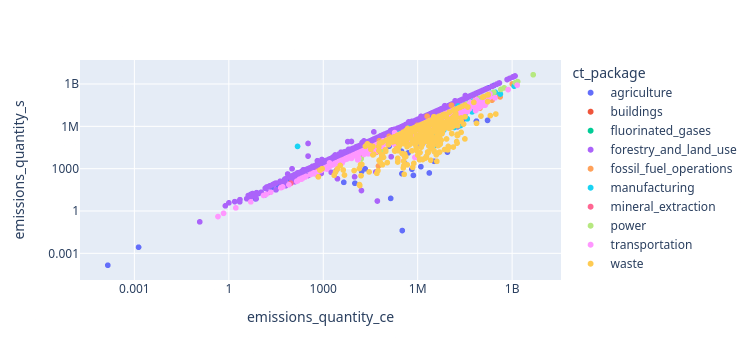

In [30]:
px.scatter(jdf_cmp, x=EMISSIONS_QUANTITY_CE, y=EMISSIONS_QUANTITY_S,
           color=CT_PACKAGE, # Does not seem to work
           hover_name=ISO3_COUNTRY,
           hover_data=[CT_PACKAGE, CT_FILE],
          log_x=True, log_y=True)

In [31]:
(jdf_cmp
 # .group_by(c_original_inventory_sector)
 .select(
    C(EMISSIONS_QUANTITY_S).sum(), C(EMISSIONS_QUANTITY_CE).sum()
))

shape: (1, 2)
┌──────────────────────┬───────────────────────┐
│ emissions_quantity_s ┆ emissions_quantity_ce │
│ ---                  ┆ ---                   │
│ f64                  ┆ f64                   │
╞══════════════════════╪═══════════════════════╡
│ 3.7621e10            ┆ 5.5172e10             │
└──────────────────────┴───────────────────────┘

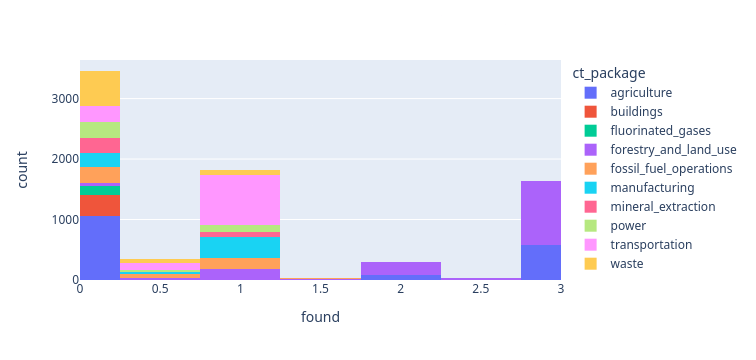

In [32]:


px.histogram(jdf_cmp, x="found",
             color=CT_PACKAGE,
             range_x=[0,3],
             nbins=5000)

In [33]:
# px.bar(
# sdf_gy.group_by(["conf_co2_emissions_factor", c_original_inventory_sector]).count().collect()
# ,facet_col="conf_co2_emissions_factor",y="count",facet_row=ORIGINAL_INVENTORY_SECTOR
# )

# Finding consistent estimates with pymc

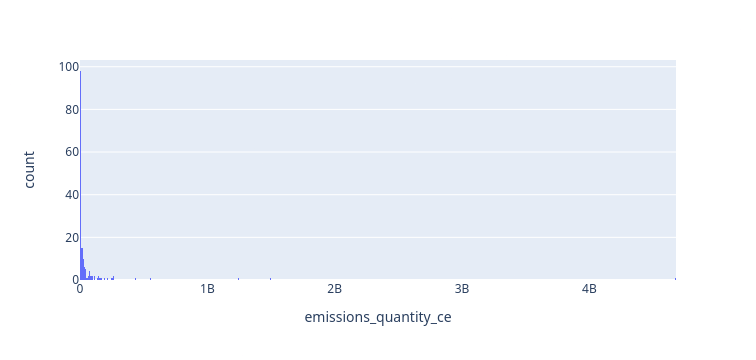

In [34]:
subs_df = (jdf_cmp
 .filter(c_ct_file == "electricity-generation")
 .filter((C("found") > 0.1) & (C("found") < 10))
 .drop_nulls()
 .sort(by=EMISSIONS_QUANTITY_S))
px.histogram(subs_df, x=EMISSIONS_QUANTITY_CE,
             hover_name=ISO3_COUNTRY,
             # log_x=True,
             # range_x=[0,3],
             nbins=500)

In [35]:
subs_df

shape: (163, 6)
┌────────────┬───────────────────┬──────────────┬───────────────────┬───────────────────┬──────────┐
│ ct_package ┆ ct_file           ┆ iso3_country ┆ emissions_quantit ┆ emissions_quantit ┆ found    │
│ ---        ┆ ---               ┆ ---          ┆ y_s               ┆ y_ce              ┆ ---      │
│ cat        ┆ cat               ┆ enum         ┆ ---               ┆ ---               ┆ f64      │
│            ┆                   ┆              ┆ f64               ┆ f64               ┆          │
╞════════════╪═══════════════════╪══════════════╪═══════════════════╪═══════════════════╪══════════╡
│ power      ┆ electricity-gener ┆ SLE          ┆ 5000.0            ┆ 16000.0           ┆ 0.3125   │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ power      ┆ electricity-gener ┆ UGA          ┆ 15000.0           ┆ 81000.0           ┆ 0.185185 │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ power      ┆ electricity-gener ┆ GNB          ┆ 27000.0           ┆ 67000.0           ┆ 0.402985 │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ power      ┆ electricity-gener ┆ TCD          ┆ 33000.0           ┆ 249000.0          ┆ 0.13253  │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ …          ┆ …                 ┆ …            ┆ …                 ┆ …                 ┆ …        │
│ power      ┆ electricity-gener ┆ RUS          ┆ 5.33325e8         ┆ 5.59267e8         ┆ 0.953614 │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ power      ┆ electricity-gener ┆ IND          ┆ 1.2134e9          ┆ 1.2486e9          ┆ 0.971774 │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ power      ┆ electricity-gener ┆ USA          ┆ 1.4893e9          ┆ 1.4955e9          ┆ 0.995854 │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
│ power      ┆ electricity-gener ┆ CHN          ┆ 4.5421e9          ┆ 4.6779e9          ┆ 0.970958 │
│            ┆ ation             ┆              ┆                   ┆                   ┆          │
└────────────┴───────────────────┴──────────────┴───────────────────┴───────────────────┴──────────┘

In [36]:
import arviz as az
import pymc as pm
import numpy as np
logging.getLogger("matplotlib").setLevel("WARNING")
logging.getLogger("filelock").setLevel("WARNING")

DEBUG:matplotlib:matplotlib data path: /home/tjhunter/work/carbonmap/science/climate_trace/.venv/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/tjhunter/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/tjhunter/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/tjhunter/.cache/matplotlib/fontlist-v330.json


In [37]:
basic_model = pm.Model()

em_s = np.array([1.4893, 2.5, 5.0])
em_ce = np.array([1.4955, 1.0, 1.0])

def shiftedGamma(mean, size):
    alpha = 8.5
    beta = 2.0
    # Putting the observed value on the mode of the distribution
    mode = (alpha-1) / beta
    # Mapping 10.m -> 0, m -> 1.0
    return mean  * (4/3. - (1.0/3) * (1.0 / mode) * pm.Gamma.dist(alpha=alpha, beta = beta, size=size))

with basic_model:
    init_est = em_ce
    epsi = pm.TruncatedNormal("epsi", mu = init_est, sigma=0.5 * init_est, lower=init_est * 0.5, upper=init_est * 10.0)
    cp = pm.CustomDist("cp", epsi, dist=shiftedGamma, observed=em_ce)
    ip = pm.CustomDist("ip", epsi, dist=shiftedGamma, observed=em_s)

# with basic_model:
#     mean = 1.0
#     alpha = 8.5
#     beta = 2.5
#     # Putting the observed value on the mode of the distribution
#     mode = (alpha-1) / beta
#     # Mapping 4.m -> 0, m -> 1.0
#     res = pm.Deterministic("pc", mean * (4/3. - (1.0/3) * (1.0 / mode) * pm.Gamma("gam", alpha=alpha, beta = beta)))


In [38]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [epsi]


DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: 1531.2619304730674.
DEBUG:pymc.stats.convergence:Energy change in leapfrog step is too large: inf.
DEBUG:pymc.stats.convergence:Energy c

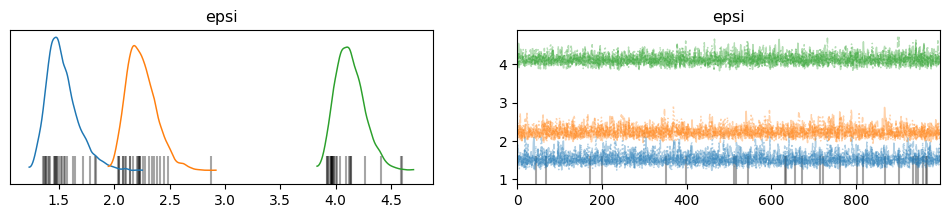

In [39]:
az.plot_trace(idata, combined=True);

In [40]:
az.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
epsi[0]  1.53  0.14    1.28     1.79        0.0      0.0   2814.46   2120.88   
epsi[1]  2.25  0.14    2.02     2.50        0.0      0.0   2449.41   1774.92   
epsi[2]  4.13  0.13    3.91     4.38        0.0      0.0   3219.41   2628.10   

         r_hat  
epsi[0]    1.0  
epsi[1]    1.0  
epsi[2]    1.0

# Analyzing error bounds

In [41]:
df= (sdf_gy
 .group_by([c_iso3_country, c_ct_file, c_conf_total_co2e_100yrgwp, c_ct_package])
 .agg(pl.count().alias("count"), c_emissions_quantity.sum())
 .collect()
 # .sort(by=[ORIGINAL_INVENTORY_SECTOR, "conf_total_co2e_100yrgwp"])
 .sort(by=c_emissions_quantity)
)
df

shape: (5_585, 6)
┌──────────────┬──────────────────┬──────────────────┬──────────────────┬───────┬──────────────────┐
│ iso3_country ┆ ct_file          ┆ conf_total_co2e_ ┆ ct_package       ┆ count ┆ emissions_quanti │
│ ---          ┆ ---              ┆ 100yrgwp         ┆ ---              ┆ ---   ┆ ty               │
│ enum         ┆ cat              ┆ ---              ┆ cat              ┆ u32   ┆ ---              │
│              ┆                  ┆ cat              ┆                  ┆       ┆ f64              │
╞══════════════╪══════════════════╪══════════════════╪══════════════════╪═══════╪══════════════════╡
│ BRA          ┆ removals         ┆ medium           ┆ forestry_and_lan ┆ 5597  ┆ -4.8601e9        │
│              ┆                  ┆                  ┆ d_use            ┆       ┆                  │
│ COD          ┆ removals         ┆ medium           ┆ forestry_and_lan ┆ 267   ┆ -4.6924e9        │
│              ┆                  ┆                  ┆ d_use            ┆       ┆                  │
│ AGO          ┆ removals         ┆ medium           ┆ forestry_and_lan ┆ 177   ┆ -3.4949e9        │
│              ┆                  ┆                  ┆ d_use            ┆       ┆                  │
│ MOZ          ┆ removals         ┆ medium           ┆ forestry_and_lan ┆ 141   ┆ -3.0537e9        │
│              ┆                  ┆                  ┆ d_use            ┆       ┆                  │
│ …            ┆ …                ┆ …                ┆ …                ┆ …     ┆ …                │
│ AGO          ┆ forest-land-fire ┆ low              ┆ forestry_and_lan ┆ 170   ┆ 3.3166e9         │
│              ┆ s                ┆                  ┆ d_use            ┆       ┆                  │
│ COD          ┆ forest-land-fire ┆ low              ┆ forestry_and_lan ┆ 219   ┆ 3.6139e9         │
│              ┆ s                ┆                  ┆ d_use            ┆       ┆                  │
│ MOZ          ┆ forest-land-fire ┆ low              ┆ forestry_and_lan ┆ 141   ┆ 3.7217e9         │
│              ┆ s                ┆                  ┆ d_use            ┆       ┆                  │
│ CHN          ┆ electricity-gene ┆ medium           ┆ power            ┆ 1225  ┆ 4.5421e9         │
│              ┆ ration           ┆                  ┆                  ┆       ┆                  │
└──────────────┴──────────────────┴──────────────────┴──────────────────┴───────┴──────────────────┘

In [62]:
import scipy as sp
margins = {"very high": 0.01, "high": 0.05,"medium":0.25, "low": 0.5, "very low": 1.}
# margins = {"very high": 0.01, "high": 0.05,"medium":0.1, "low": 0.15, "very low": 0.2}

ERR_MARGIN = "err_margin"
rankings = (df.with_columns(
    (c_conf_total_co2e_100yrgwp.replace(margins, return_dtype=pl.Float32, default=margins["very low"])
      * c_emissions_quantity).alias(ERR_MARGIN)
).group_by(c_iso3_country, c_ct_file, c_ct_package)
 .agg(c_emissions_quantity.sum(), C(ERR_MARGIN).sum())
 .sort(by=ERR_MARGIN, descending=True)
 .with_row_index()
)

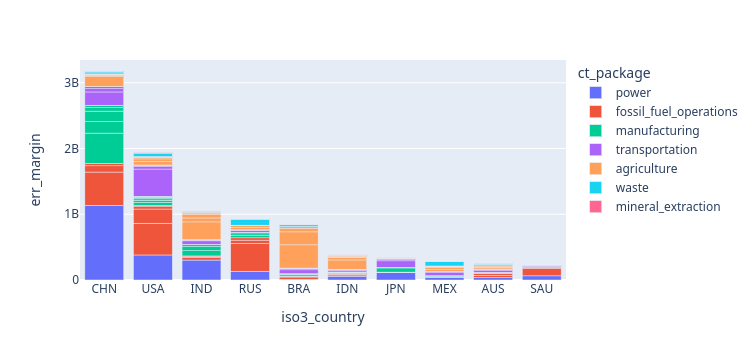

In [63]:
_plot_data = (rankings
        .filter(~(c_ct_package == "forestry_and_land_use")))
_country_order = (_plot_data
                 .group_by(c_iso3_country)
                 .agg(C(ERR_MARGIN).sum())
                 .sort(by=ERR_MARGIN, descending=True)[ISO3_COUNTRY].to_list())
px.bar(_plot_data.filter(c_iso3_country.is_in(_country_order[:10])), x=ISO3_COUNTRY,
       y=ERR_MARGIN, 
       color=CT_PACKAGE,
       hover_name=CT_FILE, 
       category_orders = {ISO3_COUNTRY: country_order},
       log_y=False)

In [64]:
rankings.select(c_emissions_quantity.sum(), C(ERR_MARGIN).sum())

shape: (1, 2)
┌────────────────────┬────────────┐
│ emissions_quantity ┆ err_margin │
│ ---                ┆ ---        │
│ f64                ┆ f64        │
╞════════════════════╪════════════╡
│ 3.7621e10          ┆ 2.5173e10  │
└────────────────────┴────────────┘